In [ ]:
# ============================================
# Google Colab Notebook: AI Resume Optimizer Agent
# Using LangGraph, LangChain, and Pydantic
# ============================================

# ------------------------------
# Cell 1: Install Dependencies
# ------------------------------
!pip install --quiet langchain-openai langgraph python-dotenv pydantic

# ------------------------------
# Cell 2: Set OpenAI API Key
# ------------------------------
import os

# Replace "YOUR_OPENAI_API_KEY" with your actual key, or set it via Colab Secrets.
os.environ["OPENAI_API_KEY"] = ""


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.1 MB/s eta 0:00:00


In [ ]:
# ------------------------------
# Cell 3: Imports
# ------------------------------
from typing import List, Optional, Literal, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field, validator
from dotenv import load_dotenv

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver


In [ ]:


# ------------------------------
# Cell 4: Define Pydantic Models
# ------------------------------

class WorkExperience(BaseModel):
    job_title: str = Field(description="Job title or position.")
    company: str = Field(description="The company name.")
    experience: int = Field(description="Years of experience in the job.")
    responsibilities: List[str] = Field(description="List of responsibilities in the job.")

class Education(BaseModel):
    degree: str = Field(description="Degree obtained.")
    school: str = Field(description="The university name.")
    major: str = Field(description="Major subject.")
    year: Optional[int] = Field(description="Year of graduation.")

    @validator('year', pre=True, always=True)
    def set_year(cls, v):
        return v if v is not None else 0

class Resume(BaseModel):
    """Structured resume data."""
    name: str = Field(description="Name of the person")
    professional_summary: str = Field(description="Professional summary of the person.")
    work_experience: List[WorkExperience] = Field(description="List of work experiences held by the person.")
    education: List[Education] = Field(description="List of educational qualifications of the person.")
    skills: List[str] = Field(description="List of skills relevant to the jobs.")

    @classmethod
    def mock(cls):
        return cls(
            name='Jeff',
            professional_summary=(
                'Innovative software engineer with 8+ years of experience in the tech industry. '
                'Senior Developer at Company X, Freelance Software Architect, and Junior Developer at Company Y. '
                'Proficient in developing scalable applications, optimizing system performance, and leading cross-functional teams. '
                'Fluent in English and Spanish.'
            ),
            work_experience=[
                WorkExperience(
                    job_title='Senior Developer',
                    company='Company X',
                    experience=5,
                    responsibilities=[
                        'Led the development of scalable web applications',
                        'Optimized system performance and reduced server costs',
                        'Mentored junior developers and conducted code reviews',
                        'Collaborated with product managers to define project requirements',
                        'Implemented CI/CD pipelines to streamline deployments',
                        'Developed RESTful APIs for mobile and web applications',
                        'Ensured application security and compliance with industry standards'
                    ]
                ),
                WorkExperience(
                    job_title='Freelance Software Architect',
                    company='Independent Consultant',
                    experience=2,
                    responsibilities=[
                        'Designed software architecture for various clients',
                        'Provided technical consultancy and project management',
                        'Developed custom software solutions to meet client needs',
                        'Conducted system analysis and performance tuning',
                        'Integrated third-party services and APIs',
                        'Created technical documentation and user manuals'
                    ]
                ),
                WorkExperience(
                    job_title='Junior Developer',
                    company='Company Y',
                    experience=1,
                    responsibilities=[
                        'Assisted in the development of web applications',
                        'Performed bug fixes and code maintenance',
                        'Collaborated with senior developers on project tasks',
                        'Participated in daily stand-ups and sprint planning',
                        'Wrote unit tests to ensure code quality',
                        'Contributed to open-source projects'
                    ]
                )
            ],
            education=[
                Education(
                    degree='B.Sc. Computer Science',
                    school='X University',
                    major='Computer Science',
                    year=1999
                )
            ],
            skills=[
                'Software Architecture',
                'System Optimization',
                'Team Mentorship',
                'Project Management',
                'API Development',
                'Continuous Integration/Continuous Deployment',
                'Bilingual'
            ]
        )

class Job(BaseModel):
    title: str = Field(description="Job title or position.")
    company: str = Field(description="The company name.")
    location: Optional[str] = Field(description="Location of the job.")
    salary: Optional[str] = Field(description="Salary range for the job.")
    description: str = Field(description="Detailed job description.")
    responsibilities: List[str] = Field(description="List of job responsibilities.")
    benefits: Optional[List[str]] = Field(description="List of job benefits.")
    employment_type: Optional[str] = Field(description="Type of employment (e.g., full-time, part-time).")
    posted_date: Optional[str] = Field(description="Date when the job was posted.")

    @classmethod
    def mock(cls):
        return cls(
            title='Software Engineer',
            company='Tech Corp',
            location='San Francisco, CA',
            salary='$100,000 - $120,000',
            description='We are looking for a skilled Software Engineer to join our team.',
            responsibilities=[
                "Develop and maintain web applications",
                "Collaborate with cross-functional teams",
                "Write clean, scalable, and efficient code",
                "Participate in code reviews",
                "Troubleshoot and debug applications"
            ],
            benefits=[
                "Health insurance",
                "401(k) matching",
                "Paid time off",
                "Flexible working hours"
            ],
            employment_type='Full-time',
            posted_date='2024-10-01'
        )


<ipython-input-3-d4372344cc25>:17: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('year', pre=True, always=True)


In [ ]:

# ------------------------------
# Cell 5: Tool Definitions
# ------------------------------

def process_job() -> Job:
    """Return a mock Job object (in production, fetch from DB or API)."""
    return Job.mock()

def process_resume() -> Resume:
    """Return a mock Resume object (in production, fetch from DB or API)."""
    return Resume.mock()

@tool
def get_job(field: Optional[Literal[
    'title', 'company', 'location', 'salary', 'description',
    'responsibilities', 'benefits', 'employment_type', 'posted_date'
]] = None) -> str:
    """
    Get job data.
    If `field` is provided, return that attribute; else return full dict.
    """
    job = process_job()
    if field:
        return getattr(job, field)
    return job.dict()

@tool
def get_resume(field: Optional[Literal[
    'name', 'professional_summary', 'work_experience', 'education', 'skills'
]] = None) -> str:
    """
    Get resume data.
    If `field` is provided, return that attribute; else return full dict.
    """
    resume = process_resume()
    if field:
        return getattr(resume, field)
    return resume.dict()


In [ ]:

# ------------------------------
# Cell 6: Build the LangGraph Agent
# ------------------------------

# 1. Initialize the OpenAI LLM (GPT-4o).
llm = ChatOpenAI(
    model_name="gpt-4o",
    api_key=os.getenv("OPENAI_API_KEY")
).bind_tools([get_job, get_resume])

# 2. Define the “expert” node function.
def expert(state: MessagesState):
    """
    The 'expert' node:
    - Prepend a system prompt
    - Forward user messages (and any prior conversation) into the LLM.
    """
    system_message = """
You are a resume expert. You are tasked with improving the user's resume based on a job description.
You can access both the resume and the job data using the provided tools: get_resume and get_job.

IMPORTANT:
- You must NEVER invent skills, experiences, or education that the user does not already have.
- If asked for any detail not in the resume, either fetch via tool or state that the information is unavailable.
"""
    messages = state["messages"]
    # Invoke the LLM with the system prompt plus the conversation history
    response = llm.invoke([system_message] + messages)
    return {"messages": [response]}


In [ ]:

# 3. Build the LangGraph structure.
tool_node = ToolNode([get_job, get_resume])
graph = StateGraph(MessagesState)

# Add nodes: first, the expert; second, the tool router.
graph.add_node("expert", expert)
graph.add_node("tools", tool_node)

# Edge from START to expert
graph.add_edge(START, "expert")

# If the LLM’s response contains a tool call, route to the tools node; else end.
def should_continue(state: MessagesState) -> Literal["tools", END]:
    last_msg = state["messages"][-1]
    if last_msg.tool_calls:
        return "tools"
    return END

graph.add_conditional_edges("expert", should_continue)
graph.add_edge("tools", "expert")

# 4. MemorySaver for conversation history
checkpointer = MemorySaver()

# 5. Compile the graph into a runnable app
app = graph.compile(checkpointer=checkpointer)

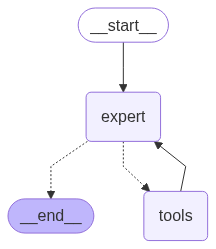

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:


# ------------------------------
# Cell 7: Interactive Loop / Example Usage
# ------------------------------

# Option A: Interactive console loop (works if you run in a Python REPL environment)
# --------------------------------------------------------------------------------
# Uncomment below to use:
#
# while True:
#     user_input = input("You: ")
#     if user_input.strip().lower() in ["quit", "exit"]:
#         print("Agent: Exiting...")
#         break
#     response = app.invoke(
#         {"messages": [HumanMessage(content=user_input)]},
#         config={"configurable": {"thread_id": 1}}
#     )
#     print("Agent:", response["messages"][-1].content)

# Option B: One-shot example query (ideal for Colab cell execution)
# -----------------------------------------------------------------
example_query = "Please review my resume and suggest optimizations so that it matches the Software Engineer position requirements at Tech Corp."



In [ ]:
%pip install -q langfuse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.4/275.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = ""
os.environ["LANGFUSE_SECRET_KEY"] = ""
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"  # 🇪🇺 EU region
# os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region

In [ ]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

In [ ]:
# Invoke the agent once (no prior history besides this prompt).
result = app.invoke(
    {"messages": [HumanMessage(content=example_query)]},
    config={"configurable": {"thread_id": 1}, "callbacks": [langfuse_handler]}
)


In [ ]:
print("Agent Response:\n")
print(result["messages"][-1].content)

Agent Response:

Here are further detailed suggestions to optimize your resume specifically for the Software Engineer position at Tech Corp:

### Professional Summary
- **Enhancements:**
  - Add specific programming languages or technologies that are common in web application development, like JavaScript, Python, or Java, if you have experience with them.
  - Highlight your role in "writing clean, scalable, and efficient code" and your experience with facilitating or participating in code reviews.

### Work Experience

1. **Senior Developer at Company X**
   - **Enhancements:**
     - Explicitly mention any specific technologies or methodologies used in web application development that align with Tech Corp’s needs.
     - Highlight your role in "troubleshooting and debugging applications," mentioning any tools or frameworks used.

2. **Freelance Software Architect**
   - **Enhancements:**
     - Detail your "collaboration with cross-functional teams," if applicable, to exhibit your tea